In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from datasets import Dataset, DatasetDict
import torch
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import wandb # Weights and Biase

# get model
model_id = "answerdotai/ModernBERT-large"

# get tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

sns.set_theme(font='Liberation Serif',
              rc={'figure.figsize': (7.5,3.75),
                  'font.size': 11,
                  'figure.dpi': 300,
                 })

seed = 42

In [10]:
# WandB for tracking

# Replace the variables below with your own: name, project name, and project directory
%env WANDB_PROJECT = ellipse
%env WANDB_DIR = bin
%env WANDB_NOTEBOOK_NAME = ellipsis_modernbert_hp_search.ipynb


env: WANDB_PROJECT=ellipse
env: WANDB_DIR=bin
env: WANDB_NOTEBOOK_NAME=ellipsis_modernbert_hp_search.ipynb


In [11]:
# configure logging

from transformers import logging
logging.set_verbosity_error()
%env WANDB_SILENT = true

env: WANDB_SILENT=true


## Dataset

In [ ]:
# There is a problem with the DF. It is not in UTF-8.
# Ignore if already completed

#!pip install charset-normalizer

# from charset_normalizer import from_path 
# result = from_path("data/ellipse_corpus_w_splits_prompts.csv").best() 
# print(result.encoding) # it is cp1252 encoding (whatever that is)

# #Read using the detected encoding and save as UTF-8:
# enc = result.encoding

# df = pd.read_csv("data/ellipse_corpus_w_splits_prompts.csv", encoding=enc)

# df.to_csv("data/ellipse_corpus_w_splits_prompts_utf8.csv", index=False, encoding="utf-8")


In [12]:
# load it
ellipse_df = pd.read_csv("data/ellipse_corpus_w_splits_prompts_utf8.csv")

# set up text so it includes assignment
ellipse_df['text'] = ellipse_df['full_text']+tokenizer.sep_token+ellipse_df['assignment']

# name appropriate columns so LLM can identify them
ellipse_df_clean = (
    ellipse_df[['text', 'Cohesion', 'split']]
    .rename(
        columns={
            'full_text': 'text',
            'Cohesion': 'label',
        }
    )
    .assign(label=lambda df: df.label.astype('float')) # make sure label is a float for regression
    .reset_index(drop=True)
)

ellipse_df_clean.sample(2)



,text,label,split
4399,It has been said that a positive attitude is t...,3.0,training
6306,I do agree with Former British Prime Minister ...,3.0,testing


In [13]:
# set up the data dictionary
ellipse_dd = DatasetDict({
    "train": Dataset.from_pandas(ellipse_df_clean[ellipse_df_clean["split"] == "training"].reset_index(drop=True)),
    "dev": Dataset.from_pandas(ellipse_df_clean[ellipse_df_clean["split"] == "validation"].reset_index(drop=True)),
    "test": Dataset.from_pandas(ellipse_df_clean[ellipse_df_clean["split"] == "testing"].reset_index(drop=True)),
})



In [14]:
# set up tokenizer

def tokenize_inputs(example):
    return tokenizer(example['text'])

# tokenize text
ellipse_dd_tokenized = ellipse_dd.map(tokenize_inputs, batched=True, remove_columns=['text'])

ellipse_dd_tokenized

Map:   0%|          | 0/3732 [00:00<?, ? examples/s]

Map:   0%|          | 0/829 [00:00<?, ? examples/s]

Map:   0%|          | 0/1921 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'split', 'input_ids', 'attention_mask'],
        num_rows: 3732
    })
    dev: Dataset({
        features: ['label', 'split', 'input_ids', 'attention_mask'],
        num_rows: 829
    })
    test: Dataset({
        features: ['label', 'split', 'input_ids', 'attention_mask'],
        num_rows: 1921
    })
})

In [25]:
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import mean_squared_error

# Wes' original
# # set up model and labels (regression)
# def model_init(trial): # trial parameter typically used for hyperparameter optimization
#     model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=1)
#     return model


def model_init(config):
    return AutoModelForSequenceClassification.from_pretrained(
        model_id,
        num_labels=1, # Regression
        # pooler_dropout=config.pooler_dropout
    )

# wes' original
# set up metrics
# def compute_metrics(eval_pred):
#     preds, labels = eval_pred
#     mse = mean_squared_error(labels, preds)

#     return {'mse': mse}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {"mse": mean_squared_error(logits, labels)}

### Hyperparameter Optimization

Config is based on hyperparameters used in benchmark tasks in Warner et al. (2024):

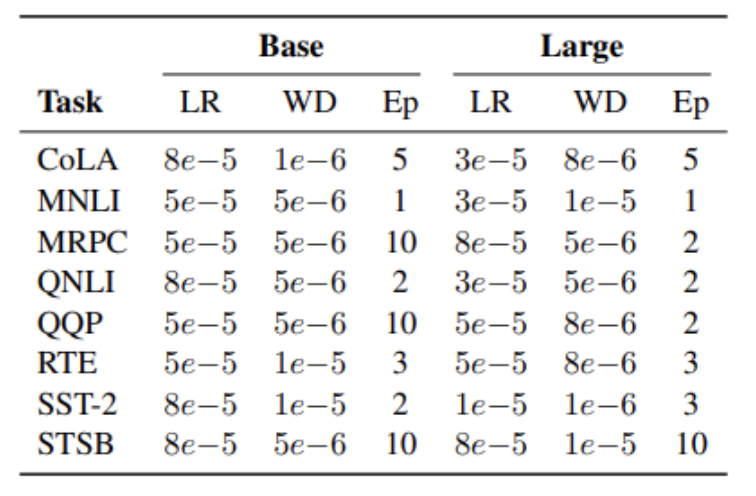

In [21]:
sweep_config = {
    'name': 'modernbert-large',
    'method': 'bayes', #bayes
    'run_cap': 42, # bayesian optimizer will run until stopped if this is not set
    'metric': {
        'name': f'eval/mse', # mean squared error
        'goal': 'minimize'}, # we want to "minimize" the mean squared error.
    'parameters': {
        'batch_size': {'value': 4}, # We will use the recommended batch size of 12 (this may be too large for memomry though)
        'gradient_accumulation_steps': {'value': 3},
        # Gradient accumulation accumulates gradients over 3 steps before updating weights, simulating a larger batch size (12 because batch size is 4)
        'learning_rate': {'values':  [1e-5, 3e-5, 5e-5, 8e-5]},
        'num_train_epochs': {'values': [1, 2, 3, 5, 10]}, 
        # 'pooler_dropout': {'values': [0, 0.15, 0.30]}, #Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of the input units to 0 during training
        'weight_decay': {'values':  [1e-6, 5e-6, 8e-6, 1e-5]}, #hyperparameter that controls the L2 regularization applied to the model's weights during training. L2 regularization is a common technique used to prevent overfitting by adding a penalty term to the loss function, proportional to the square of the model's weights
    },
}

In [31]:
training_args = TrainingArguments(
    output_dir = 'bin', 
    optim = 'adamw_torch', # Specify your optimizer
    logging_dir = 'logs', 
    load_best_model_at_end = False, # Do not load the best model at the end
    metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
    #eval_strategy='epoch', # Evaluate model performance at the end of each epoch
    save_strategy='no', # checkpoints are saved after each epoch 
    greater_is_better = False, # mse likes lower
    log_level = 'error', # only error-level messages will be logged
    disable_tqdm = False, # show progress bar
    report_to='none',
    # The hyper parameters we are tuning (number of epochs, learning rate, and batch size)
    # are called in from the configuration dictionary
    num_train_epochs=1,
    learning_rate=1e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=16,
)


# Initialize the trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=ellipse_dd_tokenized['train'].select(range(20)),
    eval_dataset=ellipse_dd_tokenized['dev'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, # this is deprecated
    # processing_class=tokenizer,
)


# Start training loop
trainer.train()

/tmp/ipykernel_173/4170366949.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss


TrainOutput(global_step=20, training_loss=0.992218017578125, metrics={'train_runtime': 4.2815, 'train_samples_per_second': 4.671, 'train_steps_per_second': 4.671, 'total_flos': 13492061124888.0, 'train_loss': 0.992218017578125, 'epoch': 1.0})

In [28]:
# This is the function we will be using for HP optimization
# Customize the trainer
score_to_predict = 'cohesion'

training_args = TrainingArguments(
    output_dir = '../bin', 
    optim = 'adamw_torch', # Specify your optimizer
    logging_dir = f'../logs/{score_to_predict}', 
    load_best_model_at_end = False,
    metric_for_best_model = 'mse', # We will be using mean squared error to evaluate model performance
    # evaluation_strategy='epoch', # Evaluate model performance at the end of each epoch
    save_strategy='no', # I prefer to perform a training run separately once the best parameters are discovered.
    warmup_steps=500,
    greater_is_better = False,
    log_level = 'error',
    # disable_tqdm = False,
    # report_to='wandb',
    # The hyper parameters we are tuning (umber of epochs, learning rate, and batch size) are called in from the configuration dictionary
    num_train_epochs=1, 
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2, 
    gradient_checkpointing=True,
)



# Initialize the trainer
trainer = Trainer(
    model=None, # this is to emphasize that we are not passing the model directly
    args=training_args,
    train_dataset=ellipse_dd_tokenized['train'].select(range(10)),
    eval_dataset=ellipse_dd_tokenized['dev'],
    compute_metrics=compute_metrics,
    #tokenizer=tokenizer, # deprecated
    processing_class=tokenizer,
    model_init=model_init, # we pass a function that initializes the model afresh at the start of each trial
)


# Start training loop
trainer.train()

{'train_runtime': 2.1624, 'train_samples_per_second': 4.624, 'train_steps_per_second': 0.462, 'train_loss': 0.0, 'epoch': 1.0}


TrainOutput(global_step=1, training_loss=0.0, metrics={'train_runtime': 2.1624, 'train_samples_per_second': 4.624, 'train_steps_per_second': 0.462, 'train_loss': 0.0, 'epoch': 1.0})